In [1]:
import pandas as pd
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


import xgboost as xgb

import numpy as np

  ### Preprocessing

In [2]:
!pip install yfinance

!pip install hpbandster-sklearn

     |████████████████████████████████| 6.4 MB 9.9 MB/s 
     |████████████████████████████████| 63 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 4.7 MB 5.4 MB/s 
     |████████████████████████████████| 51 kB 94 kB/s 
     |████████████████████████████████| 89 kB 5.1 MB/s 
  Created wheel for hpbandster: filename=hpband

In [3]:
# Load data
import yfinance as yf

btcdata = yf.download("ETH-USD", start="2020-04-01", end="2022-04-07")
df = pd.DataFrame(btcdata)
df.drop(columns=['Adj Close'],inplace=True)


df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2020-04-01,133.612320,135.634552,129.730942,135.634552,12456564435
2020-04-02,135.732178,146.787094,135.732178,142.029144,15322861686
2020-04-03,142.110458,146.899872,139.619385,142.091309,13184603402
2020-04-04,142.215179,145.377304,140.121826,145.219391,11946658257
2020-04-05,145.261017,146.128525,142.102081,143.546646,11280993591
...,...,...,...,...,...
2022-04-03,3444.810547,3573.960205,3421.259766,3522.833496,15333808649
2022-04-04,3522.364990,3535.148193,3422.000977,3521.241211,18209969743
2022-04-05,3521.239746,3546.706787,3410.547607,3411.792480,16681503199


In [5]:
# Define features set
df['Open']=df.Open.shift(-1)
df['High']=df.High.shift(-1)
df['Low']=df.Low.shift(-1)
df['Volume']=df.Low.shift(-1)
df.dropna(inplace=True)
X=df.copy()
X.drop("Close", axis=1, inplace=True)
X

,Open,High,Low,Volume
Date,,,,
2020-04-01,142.110458,146.899872,139.619385,140.121826
2020-04-02,142.215179,145.377304,140.121826,142.102081
2020-04-03,145.261017,146.128525,142.102081,143.544601
2020-04-04,143.608215,169.272644,143.544601,164.203323
2020-04-05,169.147446,175.204132,164.203323,164.493195
...,...,...,...,...
2022-03-30,3282.576172,3467.555908,3223.891357,3442.000244
2022-03-31,3449.788574,3521.284668,3442.000244,3421.259766
2022-04-01,3444.810547,3573.960205,3421.259766,3422.000977


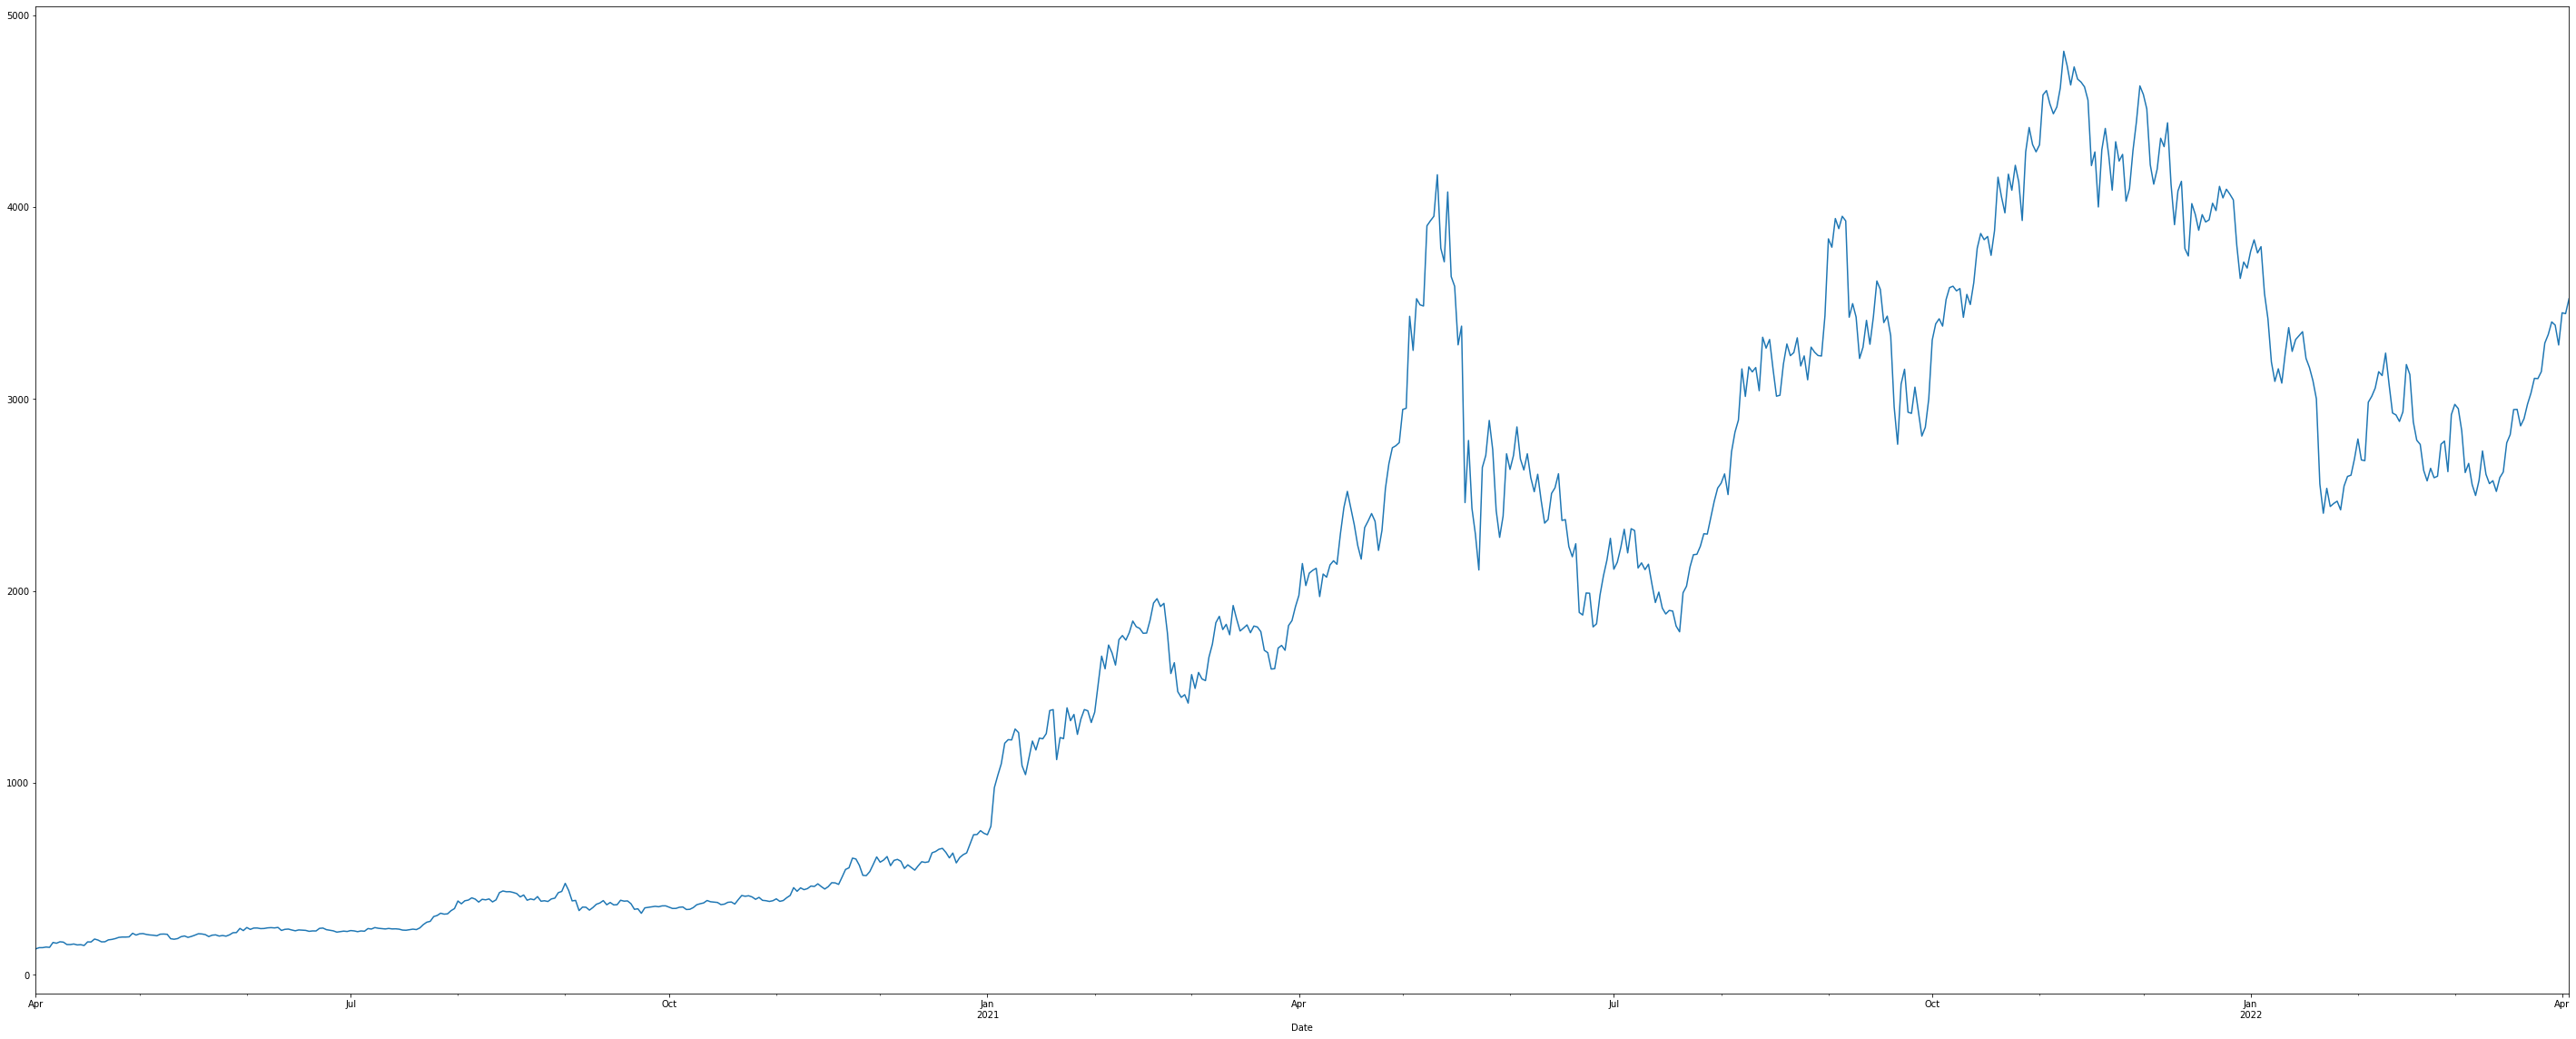

In [6]:
# Define target vector
y = df.Close
df.Close.plot(figsize=(50, 20))


In [7]:
# Splitting into Train and Test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaler
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [8]:
pd.DataFrame(y_test)

,Close
Date,
2021-08-27,3270.600830
2021-08-28,3244.403320
2021-08-29,3227.002686
2021-08-30,3224.374268
2021-08-31,3433.732666
...,...
2022-03-30,3385.157959
2022-03-31,3281.642822
2022-04-01,3449.552246


  ### Choose best learning rate

  ### Create Gradient Boosting Classifier

In [9]:
%%capture output

import warnings
warnings.filterwarnings('ignore')


from hpbandster_sklearn import HpBandSterSearchCV

param_distributions = {"max_depth": list(range(1, 10)), "learning_rate":[0,0.25,.5,.75,1]}
model = xgb.XGBRegressor(objective ='reg:linear')



search = HpBandSterSearchCV(model, param_distributions,random_state=0, n_jobs=1, n_iter=10, verbose=1).fit(X_train_scaled, y_train.ravel())
search.best_params_

In [10]:



# Choose a learning rate and create classifier
model = xgb.XGBRegressor(objective ='reg:linear', learning_rate = search.best_params_['learning_rate'],
                max_depth = search.best_params_['max_depth'], n_estimators = 100)

# Fit the model
model.fit(X_train_scaled, y_train.ravel())

# Make Prediction
predictions = model.predict(X_test_scaled)
pd.DataFrame({"Prediction": predictions, "Actual": y_test.ravel()}).head(20)

[04:13:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Prediction,Actual
0,3254.921387,3270.600830
1,3197.881104,3244.403320
2,3068.515381,3227.002686
3,3490.825928,3224.374268
4,3514.452148,3433.732666
5,3633.412598,3834.828125
6,3530.615479,3790.989990
7,3510.602051,3940.614746
8,3529.848389,3887.828369
9,4000.786377,3952.133545


  ### Evaluate the model

In [11]:
stocks = pd.DataFrame({
    "Real": y_test.ravel(),
    "Predicted": predictions.ravel()
    }, index = df.index[-len(y_test): ])
stocks.head(100)



,Real,Predicted
Date,,
2021-08-27,3270.600830,3254.921387
2021-08-28,3244.403320,3197.881104
2021-08-29,3227.002686,3068.515381
2021-08-30,3224.374268,3490.825928
2021-08-31,3433.732666,3514.452148
...,...,...
2021-11-30,4631.479004,3949.828369
2021-12-01,4586.990234,3951.013428
2021-12-02,4511.302246,4123.847168


In [1]:
stocks.plot(figsize=(50, 20))

NameError: name 'stocks' is not defined

In [13]:
from sklearn import metrics

print(f'Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, predictions), 4))
print(f'Mean Squared Error:', round(metrics.mean_squared_error(y_test, predictions), 4))
print(f'Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, predictions)), 4))
print(f'(R^2) Score:', round(metrics.r2_score(y_test, predictions), 4))
errors = abs(predictions - y_test)
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.') 

Mean Absolute Error: 232.8475
Mean Squared Error: 87280.3406
Root Mean Squared Error: 295.4325
(R^2) Score: 0.7838
Accuracy: 93.64 %.
